# Global Energy consuption/production forecasting

---



### Utils

In [152]:
def forecast_accuracy(forecast, actual):
  import warnings
  warnings.filterwarnings('ignore')
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
  me = np.mean(forecast - actual)             # ME
  mae = np.mean(np.abs(forecast - actual))    # MAE
  mpe = np.mean((forecast - actual)/actual)   # MPE
  rmse = np.mean((forecast - actual)**2)**.5  # RMSE
  corr = np.corrcoef(forecast, actual)[0,1]   # corr
  mins = np.amin(np.hstack([forecast[:,None], 
                            actual[:,None]]), axis=1)
  maxs = np.amax(np.hstack([forecast[:,None], 
                            actual[:,None]]), axis=1)
  minmax = 1 - np.mean(mins/maxs)             # minmax
  return({'mape':mape, 'me':me, 'mae': mae, 
          'mpe': mpe, 'rmse':rmse,
          'corr':corr, 'minmax':minmax})

In [153]:
! pip install statsmodels --upgrade 
! pip install geopandas

In [154]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import geopandas as gpd
import ipywidgets as widgets

In [155]:
! rm *.csv
! wget https://raw.githubusercontent.com/s1102498/Global_Energy_Analysis/main/Primary-energy-consumption-from-fossilfuels-nuclear-renewables.csv /content/
! wget https://raw.githubusercontent.com/s1102498/Global_Energy_Analysis/main/share-elec-produc-by-source.csv /content/
! wget https://raw.githubusercontent.com/s1102498/Global_Energy_Analysis/main/share-energy-consum-by-source.csv /content/

--2022-05-06 11:30:45--  https://raw.githubusercontent.com/s1102498/Global_Energy_Analysis/main/Primary-energy-consumption-from-fossilfuels-nuclear-renewables.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145200 (142K) [text/plain]
Saving to: ‘Primary-energy-consumption-from-fossilfuels-nuclear-renewables.csv’

Primary-energy-cons 100%[===================>] 141.80K  --.-KB/s    in 0.02s   

2022-05-06 11:30:45 (8.93 MB/s) - ‘Primary-energy-consumption-from-fossilfuels-nuclear-renewables.csv’ saved [145200/145200]

/content/: Scheme missing.
FINISHED --2022-05-06 11:30:45--
Total wall clock time: 0.08s
Downloaded: 1 files, 142K in 0.02s (8.93 MB/s)
--2022-05-06 11:30:46--  https://raw.githubusercontent.com/s1102498/Global_Energy_Analysis/main/share-elec

## Data analisys

In [156]:
energy_cons = pd.read_csv("Primary-energy-consumption-from-fossilfuels-nuclear-renewables.csv", low_memory=False)
energy_cons.drop(["Code"], axis=1).head()
country_dataset = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
country_dataset = country_dataset.drop(["pop_est","iso_a3","geometry","gdp_md_est"], axis=1)
df = energy_cons.merge(country_dataset, left_on = "Entity", right_on="name", how="left").drop(columns=["name"])
df.columns = map(lambda c: c.replace(" (% sub energy)", ''), df.columns)
#df = df[["Entity", "continent"]]
df

,Entity,Code,Year,Fossil fuels,Renewables,Nuclear,continent
0,Africa,NaN,1965,94.463,5.537,0.000,NaN
1,Africa,NaN,1966,94.127,5.873,0.000,NaN
2,Africa,NaN,1967,93.920,6.080,0.000,NaN
3,Africa,NaN,1968,93.257,6.743,0.000,NaN
4,Africa,NaN,1969,92.317,7.683,0.000,NaN
...,...,...,...,...,...,...,...
4279,World,OWID_WRL,2015,85.839,9.842,4.319,NaN
4280,World,OWID_WRL,2016,85.459,10.241,4.300,NaN
4281,World,OWID_WRL,2017,85.123,10.640,4.237,NaN
4282,World,OWID_WRL,2018,84.846,10.959,4.193,NaN


In [157]:
elec_prod = pd.read_csv("share-elec-produc-by-source.csv")
elec_prod.head()

,Entity,Code,Year,Coal (% electricity),Gas (% electricity),Hydro (% electricity),Solar (% electricity),Wind (% electricity),Oil (% electricity),Nuclear (% electricity),Other renewables (% electricity)
0,Afghanistan,AFG,2000,0.0,33.190578,66.809422,0.0,0.0,0.0,0.0,0.0
1,Afghanistan,AFG,2001,0.0,15.878378,84.121622,0.0,0.0,0.0,0.0,0.0
2,Afghanistan,AFG,2002,0.0,19.213974,80.786026,0.0,0.0,0.0,0.0,0.0
3,Afghanistan,AFG,2003,0.0,32.907348,67.092652,0.0,0.0,0.0,0.0,0.0
4,Afghanistan,AFG,2004,0.0,36.800895,63.199105,0.0,0.0,0.0,0.0,0.0


Per ogni anno bisogna calcolare le percentuali mondiali di produzione di energia

In [158]:
normalized = elec_prod.copy()
normalized.rename( columns =
  dict(
    map(
      lambda column: (column, column.split("(")[0].strip() + "_perc"),
      filter(
        lambda column: "%" in column, normalized.columns
      )
    )
  ),
  inplace = True
)
normalized.columns

Index(['Entity', 'Code', 'Year', 'Coal_perc', 'Gas_perc', 'Hydro_perc',
       'Solar_perc', 'Wind_perc', 'Oil_perc', 'Nuclear_perc',
       'Other renewables_perc'],
      dtype='object')

In [159]:
renw = ["Solar_perc", "Hydro_perc", "Wind_perc", "Other renewables_perc"]
fossil = ["Coal_perc", "Gas_perc", "Oil_perc"]

normalized["Renewables"] = normalized[renw].sum(axis = 1)  
normalized["Fossil"] = normalized[fossil].sum(axis = 1) 
normalized["Nuclear"] = normalized.Nuclear_perc
normalized.loc[normalized.Entity == "World"].head()

,Entity,Code,Year,Coal_perc,Gas_perc,Hydro_perc,Solar_perc,Wind_perc,Oil_perc,Nuclear_perc,Other renewables_perc,Renewables,Fossil,Nuclear
6094,World,OWID_WRL,1985,37.934470,14.397493,20.039768,0.000119,0.000650,11.223154,15.071231,0.787432,20.827970,63.555116,15.071231
6095,World,OWID_WRL,1986,37.726145,14.043181,19.722481,0.000149,0.001365,11.462997,15.674569,0.841153,20.565147,63.232324,15.674569
6096,World,OWID_WRL,1987,38.045296,14.186852,19.070143,0.000099,0.001832,11.074492,16.266659,0.859339,19.931413,63.306640,16.266659
6097,World,OWID_WRL,1988,37.716902,13.801174,18.850563,0.000092,0.002978,11.265927,16.987067,0.846823,19.700456,62.784004,16.987067
6098,World,OWID_WRL,1989,37.559033,14.796554,17.912961,0.002250,0.022737,11.555905,16.689684,0.895388,18.833337,63.911492,16.689684


# FORECASTING using ARIMA and SARIMA

In [160]:
continents = df.continent.unique()
continents = continents[~pd.isna(continents)]
continents = np.append(continents, "World")
c_dropdown = widgets.Dropdown(
    options=continents,
    value='Europe',
    description='Select Continent:',
    disabled=False,
    continuous_update=True
)

display(c_dropdown)

Dropdown(description='Select Continent:', index=3, options=('Africa', 'South America', 'Oceania', 'Europe', 'A…

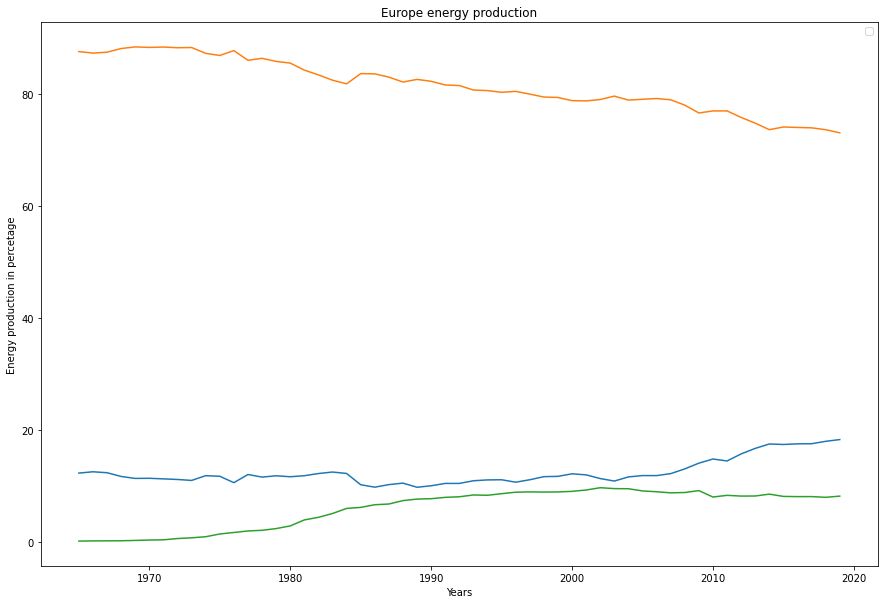

In [161]:
watch = c_dropdown.value #"World"
if watch == "World":
  w = normalized.loc[normalized.Entity == watch, ["Year", "Renewables", "Fossil", "Nuclear"] + list(filter(lambda c: "_" in c, normalized.columns))]
else:
  df.loc[df["Entity"] == watch]["continent"] = watch
  df_continent = df.loc[df["continent"] == watch, ["Entity"]].reset_index(drop=True)
  #w = normalized.loc[normalized.Entity.isin(df_continent.Entity), ["Year", "Renewables", "Fossil", "Nuclear"] + list(filter(lambda c: "_" in c, normalized.columns))]
  w = df.loc[df.Entity.isin(df_continent.Entity.unique()), ["Year", "Renewables", "Fossil fuels", "Nuclear"]]
  w.rename(columns={"Fossil fuels":"Fossil"},  inplace = True)
  w = w.groupby("Year").mean().reset_index() 

plt.rcParams["figure.figsize"] = (15,10)
plt.plot(w.Year, w.drop("Year", axis = 1))
plt.legend(list(filter(lambda c: "_" in c, w.columns)), bbox_to_anchor=(1, 1))
plt.title(f"{watch} energy production")
plt.xlabel("Years")
plt.ylabel("Energy production in percetage")
plt.show()

In [162]:
w.columns

Index(['Year', 'Renewables', 'Fossil', 'Nuclear'], dtype='object')

In [163]:
if watch == "World":
  perc_columns = list(filter(lambda c: "_" in c, w.columns))
  [autocorrelation_plot(w[column], label = column.split("_")[0]+" %") for column in perc_columns]
  plt.legend(bbox_to_anchor = (1,1))
  plt.title("Autocorrelations Chart")
  plt.show()
else:
  print("Skipping...")

Skipping...


## Finding the order of differenziation (d)
ADF test for stationary series
Null Hipotesys: series is not stationary

if p value > crit value => series is non stationary

In [164]:
#@markdown ##ADF test significance level select. {run: "auto"}
significance_level = "10%" #@param ["1%", "5%", "10%"] 
significance_level_n = int(significance_level.split("%")[0])/100
# ADF Test function
def perform_adf(series):
  result = adfuller(series, autolag='AIC')
  return result

results = {serie: perform_adf(w[serie]) for serie in ["Fossil", "Renewables", "Nuclear"]}
results_d1 = {serie + " d1": perform_adf(w[serie].diff().dropna()) for serie in ["Fossil", "Renewables", "Nuclear"]}
results_d2 = {serie + " d2": perform_adf(w[serie].diff().diff().dropna()) for serie in ["Fossil", "Renewables", "Nuclear"]}

results.update(results_d1)
results.update(results_d2)

for ser, res in results.items():
  is_stat = "non stationary" if res[1] > significance_level_n else "stationary"
  print(f"{ser} results: {is_stat}")
  print(f"\tADF Test statistic: {res[0]}")
  print(f"\t\tp value: {res[1]}")
  print(f"\t\tn lags: {res[2]}")
  print(f"\t\tn observation used: {res[3]}")
  print(f"\tCRITICAL VALUES:")
  print(f"\t\t{significance_level}: {res[4][significance_level]}")
  #for key, val in res[4].items():
  #  print(f"\t\t{key}: {val}")
  print()

Fossil results: non stationary
	ADF Test statistic: 0.35694429461375715
		p value: 0.9798114114690926
		n lags: 0
		n observation used: 54
	CRITICAL VALUES:
		10%: -2.59622219478738

Renewables results: non stationary
	ADF Test statistic: 0.8744137247226078
		p value: 0.9927471668775035
		n lags: 0
		n observation used: 54
	CRITICAL VALUES:
		10%: -2.59622219478738

Nuclear results: stationary
	ADF Test statistic: -2.6273034502962314
		p value: 0.08748447045440705
		n lags: 5
		n observation used: 49
	CRITICAL VALUES:
		10%: -2.5993358475635153

Fossil d1 results: stationary
	ADF Test statistic: -7.378532600097582
		p value: 8.593884097785793e-11
		n lags: 0
		n observation used: 53
	CRITICAL VALUES:
		10%: -2.5967964150943397

Renewables d1 results: stationary
	ADF Test statistic: -6.444757930155861
		p value: 1.575920909792253e-08
		n lags: 0
		n observation used: 53
	CRITICAL VALUES:
		10%: -2.5967964150943397

Nuclear d1 results: non stationary
	ADF Test statistic: -1.2823240968918

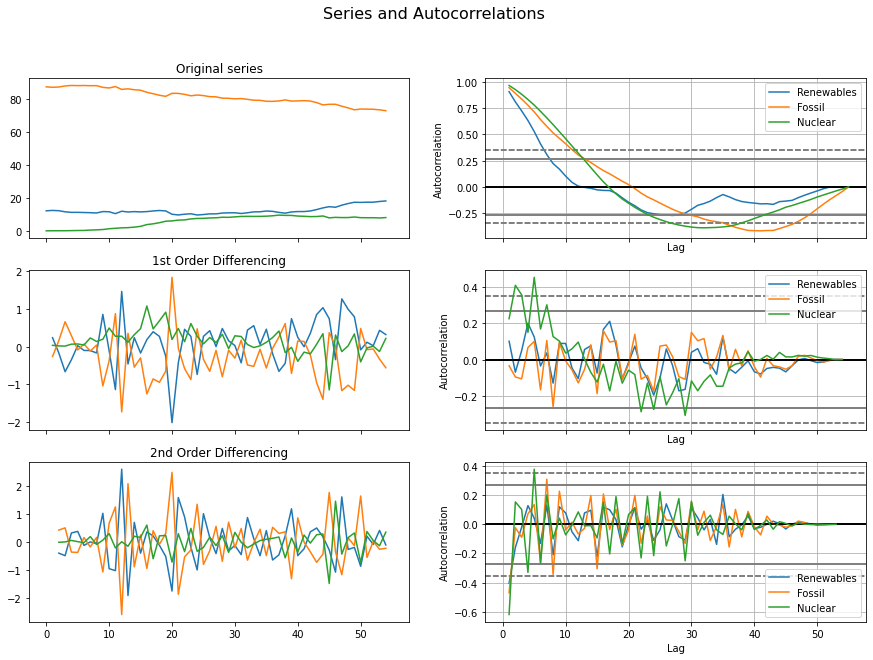

In [165]:
fig, axes = plt.subplots(3, 2, sharex=True)
indexes = w.Year
if watch == "World":
  df = w.drop(["Year"] + perc_columns, axis = 1)
else:
  df = w.drop(["Year"], axis = 1)
plt.rcParams["figure.figsize"] = (20,15)

fig.suptitle("Series and Autocorrelations", fontsize=16)

axes[0, 0].plot(df.values)
axes[0, 0].set_title('Original series')
#[plot_acf(w[s], ax=axes[0, 1]) for s in perc_columns]
[autocorrelation_plot(df[column], label = column, ax=axes[0,1]) for column in df.columns]
#axes[0,0].labels(bbox_to_anchor = (1,1))

# 1st Differencing

axes[1, 0].plot(df.diff().values)
axes[1, 0].set_title('1st Order Differencing')
#plot_acf(w[perc_columns].diff().dropna(), ax=axes[1, 1])
[autocorrelation_plot(df[column].diff().dropna().values, ax=axes[1,1], label = column) for column in df.columns]

# 2nd Differencing
axes[2, 0].plot(df.diff().diff().values)
axes[2, 0].set_title('2nd Order Differencing')
#plot_acf(w[perc_columns].value.diff().diff().dropna(), ax=axes[2, 1])
[autocorrelation_plot(df[column].diff().diff().dropna().values, ax=axes[2,1], label = column) for column in df.columns]

plt.show()

In [166]:
arima_d_nuclear = 2
arima_d_fossil = 1
arima_d_renewables = 1

## Finding the AR order term (p)
For Fossil, Nuclear and Renewables

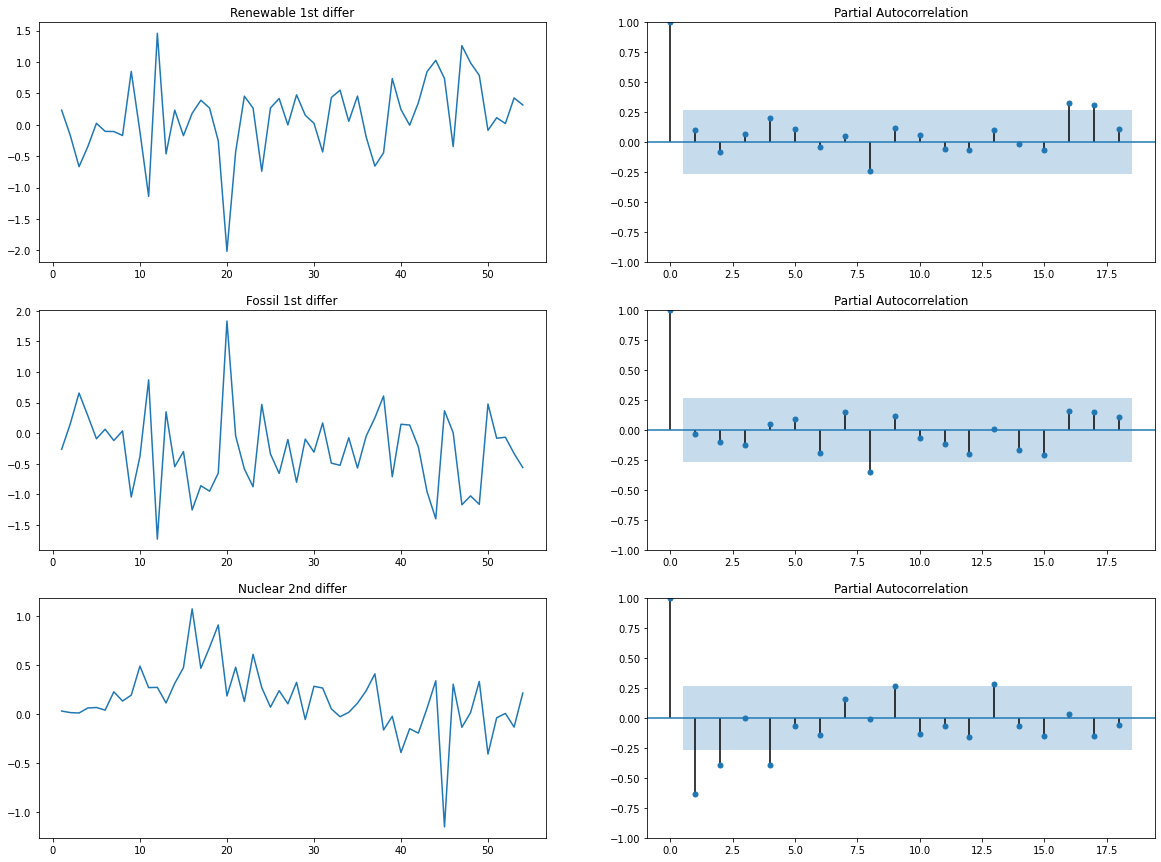

In [167]:
fig, axes = plt.subplots(3, 2)

axes[0,0].plot(df.Renewables.diff())
axes[0,0].set_title("Renewable 1st differ")
plot_pacf(df.Renewables.diff().dropna(), ax = axes[0,1])

axes[1,0].plot(df.Fossil.diff())
axes[1,0].set_title("Fossil 1st differ")
plot_pacf(df.Fossil.diff().dropna(), ax = axes[1,1])

axes[2,0].plot(df.Nuclear.diff())
axes[2,0].set_title("Nuclear 2nd differ")
plot_pacf(df.Nuclear.diff().diff().dropna(), ax = axes[2,1])

plt.show()

In [168]:
arima_p_renewables = 1
arima_p_fossil = 1
arima_p_nuclear = 2

## Finding ARIMA MA order term (q)

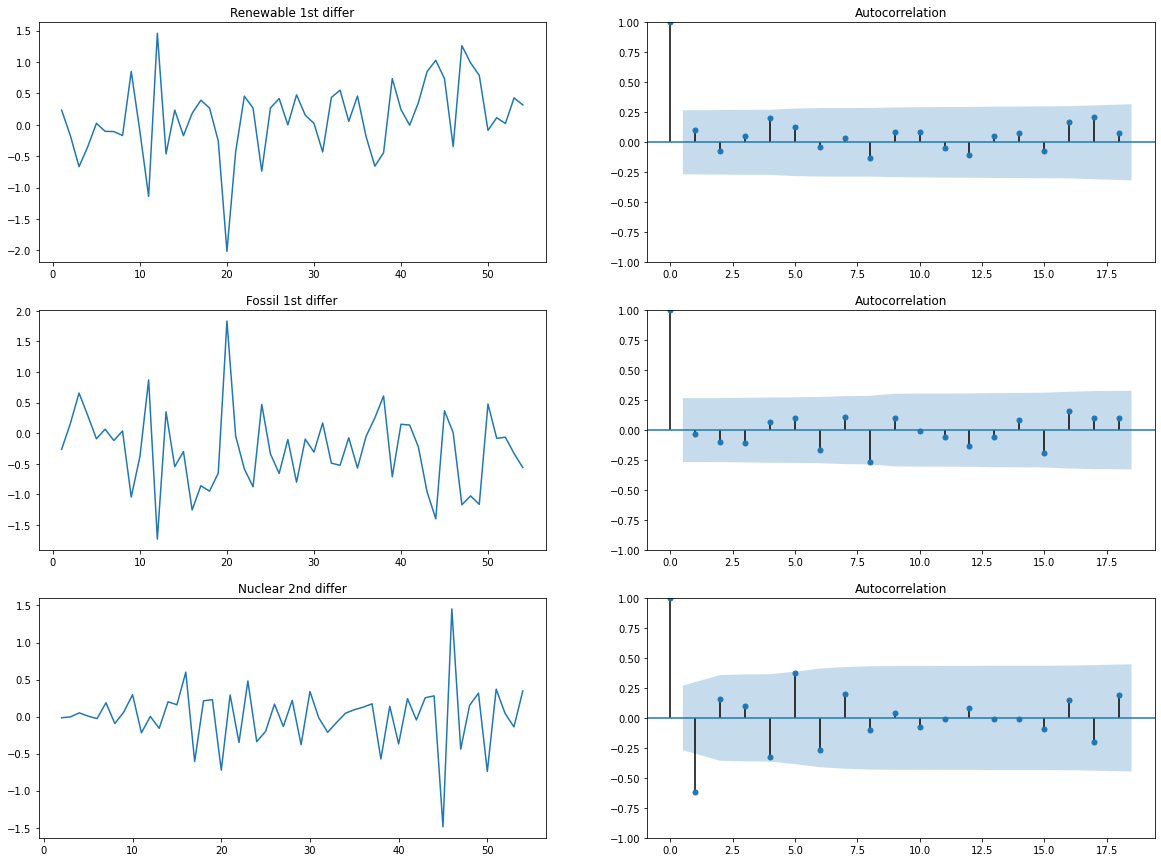

In [169]:
fig, axes = plt.subplots(3, 2)

axes[0,0].plot(df.Renewables.diff())
axes[0,0].set_title("Renewable 1st differ")
plot_acf(df.Renewables.diff().dropna(), ax = axes[0,1])

axes[1,0].plot(df.Fossil.diff())
axes[1,0].set_title("Fossil 1st differ")
plot_acf(df.Fossil.diff().dropna(), ax = axes[1,1])

axes[2,0].plot(df.Nuclear.diff().diff())
axes[2,0].set_title("Nuclear 2nd differ")
plot_acf(df.Nuclear.diff().diff().dropna(), ax = axes[2,1])

plt.show()

In [170]:
arima_q_renewables = 1
arima_q_fossil = 1
arima_q_nuclear = 2

## Building ARIMA models


Metrichs:
mape: 0.023694969027368777
me: -1.4840313173487953
mae: 2.041609871424647
mpe: -0.016828776483632693
rmse: 11.82596992970798
corr: 0.21221400278783673
minmax: 0.023661467500109112

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   55
Model:                 ARIMA(3, 1, 4)   Log Likelihood                 -49.750
Date:                Fri, 06 May 2022   AIC                            115.499
Time:                        11:30:55   BIC                            131.411
Sample:                             0   HQIC                           121.636
                                 - 55                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8

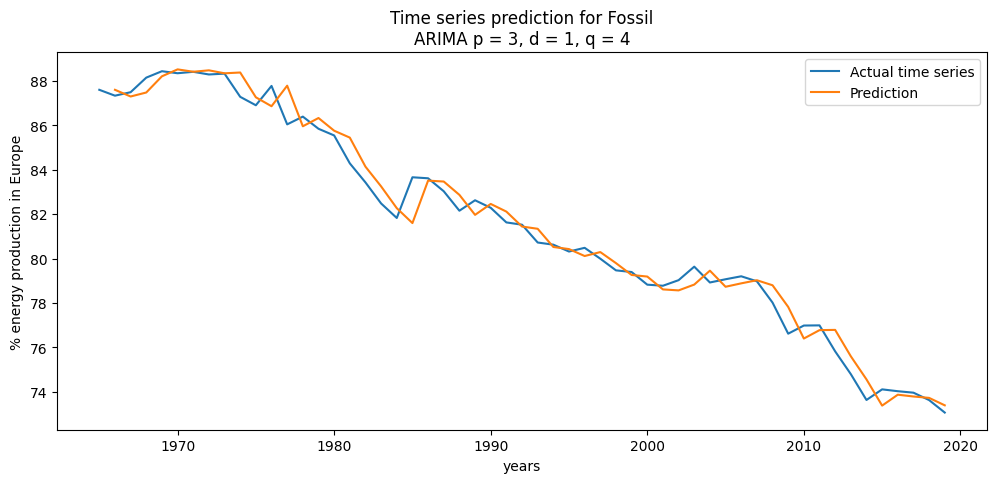

In [171]:
#@title ARIMA training.
#@markdown Execute all cells below when you change the "what" field
what = "Fossil" #@param ["Nuclear", "Renewables", "Fossil"]
verbose = True #@param {type:"boolean"}

if what == "Nuclear":
  model = ARIMA(df[what].values, order = (arima_p_nuclear, arima_d_nuclear, arima_q_nuclear))
  used = [arima_p_nuclear, arima_d_nuclear, arima_q_nuclear]

elif what == "Fossil":
  model = ARIMA(df[what].values, order = (arima_p_fossil, arima_d_fossil, arima_q_fossil))
  used = [arima_p_fossil, arima_d_fossil, arima_q_fossil]

elif what == "Renewables":
  model = ARIMA(df[what].values, order = (arima_p_renewables, arima_d_renewables, arima_q_renewables))
  used = [arima_p_renewables, arima_d_renewables, arima_q_renewables]

model_fitted = model.fit()
bestp = used[0]
bestq = used[2]
pred = model_fitted.get_prediction(dynamic=False).predicted_mean

""" ACCURACY CALC """
met = forecast_accuracy(pred, df[what].values)
mape = met["mape"]

for p in range(1,5):
  for q in range(1,5):
    if p == used[0] and q == used[2]: continue
    newmodel = ARIMA(df[what].values, order = (p, used[1], q))
    newmodel_fitted = newmodel.fit()
    newpred = newmodel_fitted.get_prediction(dynamic=False).predicted_mean
    newmet = forecast_accuracy(newpred, df[what].values)
    if newmet["mape"] < mape:
      met = newmet
      mape = met["mape"]
      model = newmodel
      model_fitted = newmodel_fitted
      bestp = p
      bestq = q
      

print("\nMetrichs:")
print(*[f"{key}: {val}" for key, val in met.items()], sep="\n")
print()
if verbose:
  print(model_fitted.summary())
  print()
  # LATEX
  print(pd.DataFrame.from_dict(met, orient="index").to_latex())

plt.figure(figsize=(12,5), dpi=100)
plt.plot(indexes, df[what].values, label = "Actual time series")
plt.plot(indexes[1:], pred[1:], label = "Prediction")
plt.title(f'Time series prediction for {what}\nARIMA p = {bestp}, d = {used[1]}, q = {bestq}')
plt.legend()
plt.ylabel(f"% energy production in {watch}")
plt.xlabel("years")
plt.show()


### Models Diagnostics
- **Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

- **Top Right**: The density plot suggest near a normal distribution with mean zero.

- **Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

- **Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

[]

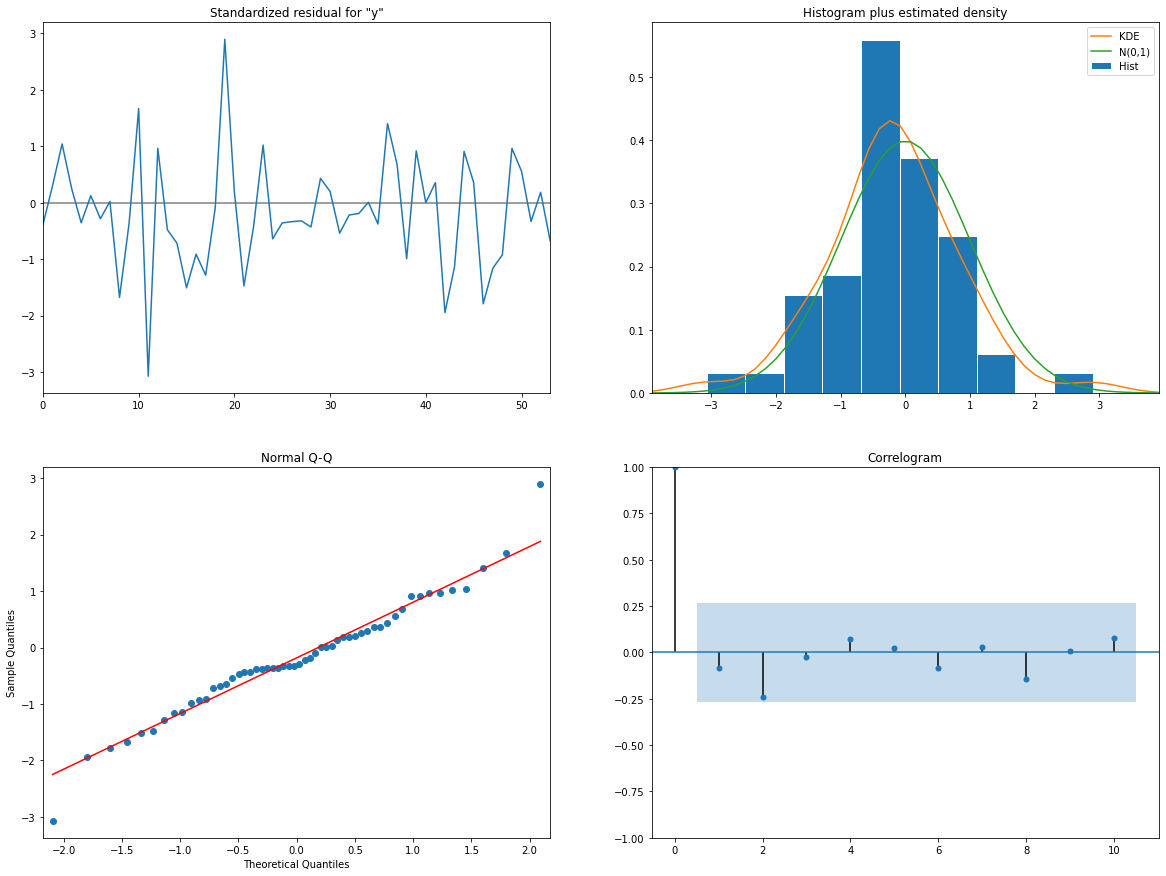

In [172]:
model_fitted.plot_diagnostics()
plt.plot()

## Forecasting

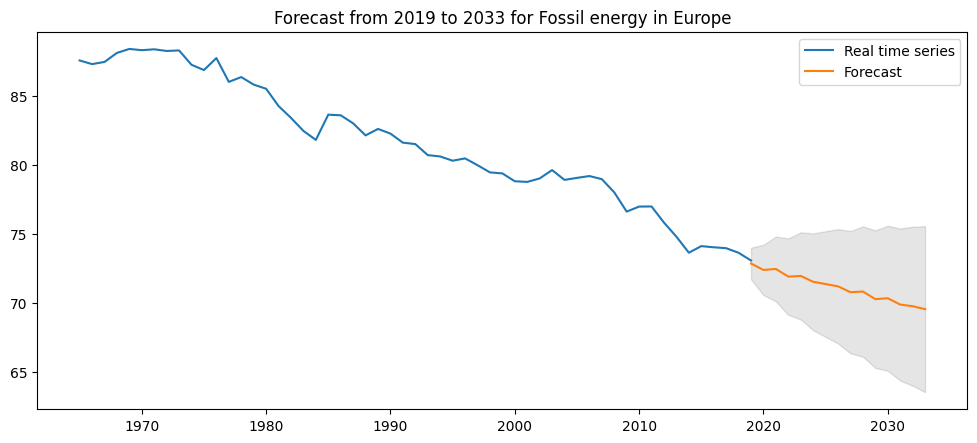

In [173]:
#@title ARIMA forecasting. { run: "auto" }
n_pred = 14 #@param {type:"slider", min:1, max:35, step:1}
n_pred += 1

fc = model_fitted.get_forecast(steps=n_pred).summary_frame()

upper = fc['mean_ci_upper']
lower = fc['mean_ci_lower']
forecast = fc['mean']
new_idxs = range(indexes.to_list()[-1], indexes.to_list()[-1] + n_pred)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(indexes, df[what].values, label = "Real time series")
plt.plot(new_idxs, forecast, label = "Forecast")
plt.fill_between(new_idxs, lower, upper, color='k', alpha=0.1);
plt.legend()
plt.title(f"Forecast from {new_idxs[0]} to {new_idxs[-1]} for {what} energy in {watch}")
plt.show()

## SARIMA

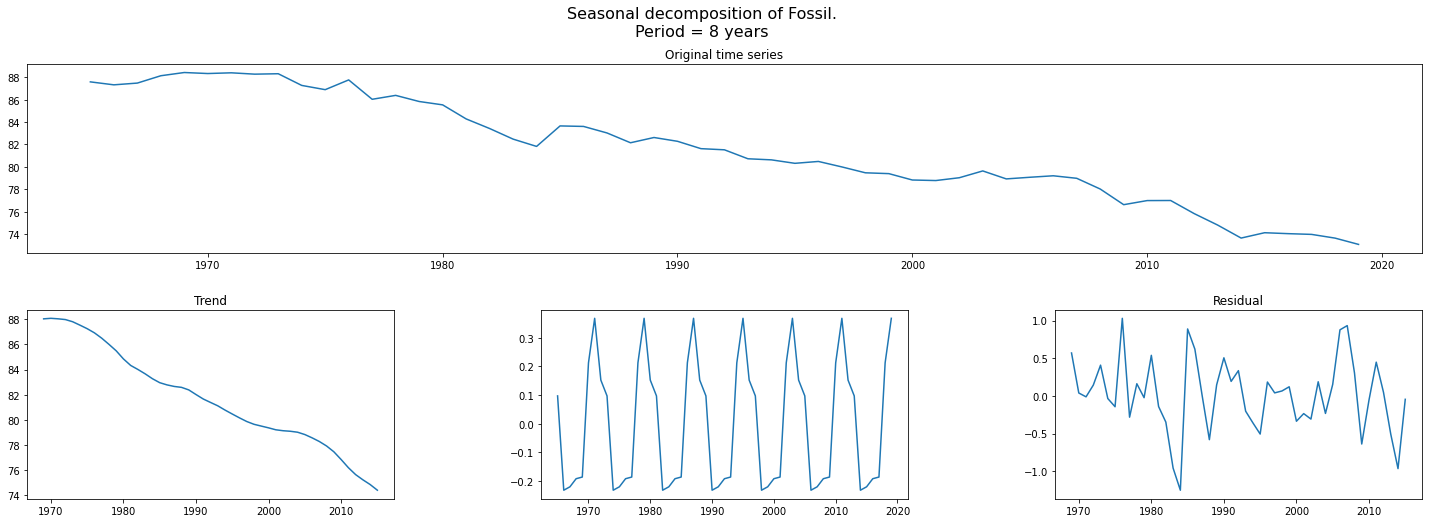

In [174]:
#@title Looking for seasonalities
custom_period = 8 #@param {type:"slider", min:2, max:15, step:1}
use_custom_period = True #@param {type:"boolean"}
from statsmodels.tsa.seasonal import seasonal_decompose

if what == "Fossil":
  period = 20
elif what == "Renewables":
  period = 15
elif what == "Nuclear":
  period = 20
if use_custom_period:
  period = custom_period

try:
  res = seasonal_decompose(df[what], period = period)
except:
  print(f"not enough data, using custom period: {custom_period}")
  period = custom_period
  res = seasonal_decompose(df[what], period = period)
finally:
  resid = res.resid
  err = np.mean(resid)
  std = np.std(resid)

  fig = plt.figure(figsize = (25,8))
  grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)

  orig = fig.add_subplot(grid[0,:])
  trend = fig.add_subplot(grid[1,0])
  seaso = fig.add_subplot(grid[1,1])
  resid = fig.add_subplot(grid[1,2])

  orig.plot(indexes, df[what])
  orig.set_title("Original time series")
  trend.plot(indexes,res.trend)
  trend.set_title(f"Trend")
  seaso.plot(indexes,res.seasonal)
  resid.plot(indexes,res.resid)
  resid.set_title(f"Residual")
  fig.suptitle(f'Seasonal decomposition of {what}.\nPeriod = {period} years', fontsize = 16)
  fig.show()


Metrichs:
mape: 0.023766053572648726
me: -1.4714865972868738
mae: 2.0471241760401546
mpe: -0.016670864634523427
rmse: 11.825533738032087
corr: 0.21187750765230293
minmax: 0.023731518155994058

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                   55
Model:             SARIMAX(3, 1, 4)x(2, 0, [1, 2], 8)   Log Likelihood                 -48.797
Date:                                Fri, 06 May 2022   AIC                            121.594
Time:                                        11:31:03   BIC                            145.462
Sample:                                             0   HQIC                           130.799
                                                 - 55                                         
Covariance Type:                                  opg                                         
                 coef    std err          z   

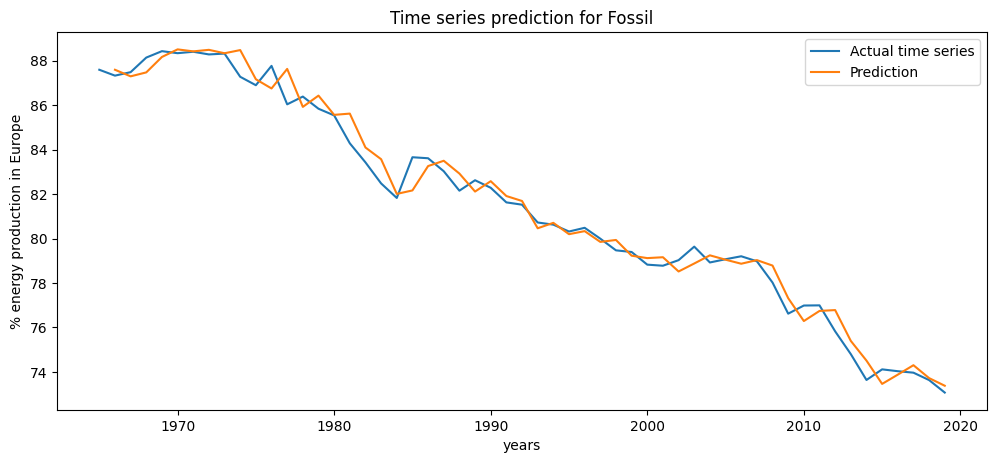

In [175]:
#@title SARIMA training. { run: "auto" }
# 2,0,2 Renewables
# 0,0,2 Nuclear
# 2,0,2 Fossil
if what == "Renewables" or what == "Fossil":
  sused = [2,0,2]
else:
  sused = [0,0,2]
smodel = SARIMAX(df[what].values, order = (bestp, used[1], bestq), seasonal_order = (sused[0],sused[1],sused[2],period))
smodel_fitted = smodel.fit()
pred = smodel_fitted.get_prediction(dynamic=False).predicted_mean
met = forecast_accuracy(pred, df[what].values)
print("\nMetrichs:")
print(*[f"{key}: {val}" for key, val in met.items()], sep="\n")
print()
if verbose:
  print(smodel_fitted.summary())
  print()
  print(pd.DataFrame.from_dict(met, orient="index").to_latex())

plt.figure(figsize=(12,5), dpi=100)
plt.plot(indexes, df[what].values, label = "Actual time series")
plt.plot(indexes[1:], pred[1:], label = "Prediction")
plt.title(f'Time series prediction for {what}')
plt.legend()
plt.ylabel(f"% energy production in {watch}")
plt.xlabel("years")
plt.show()

[]

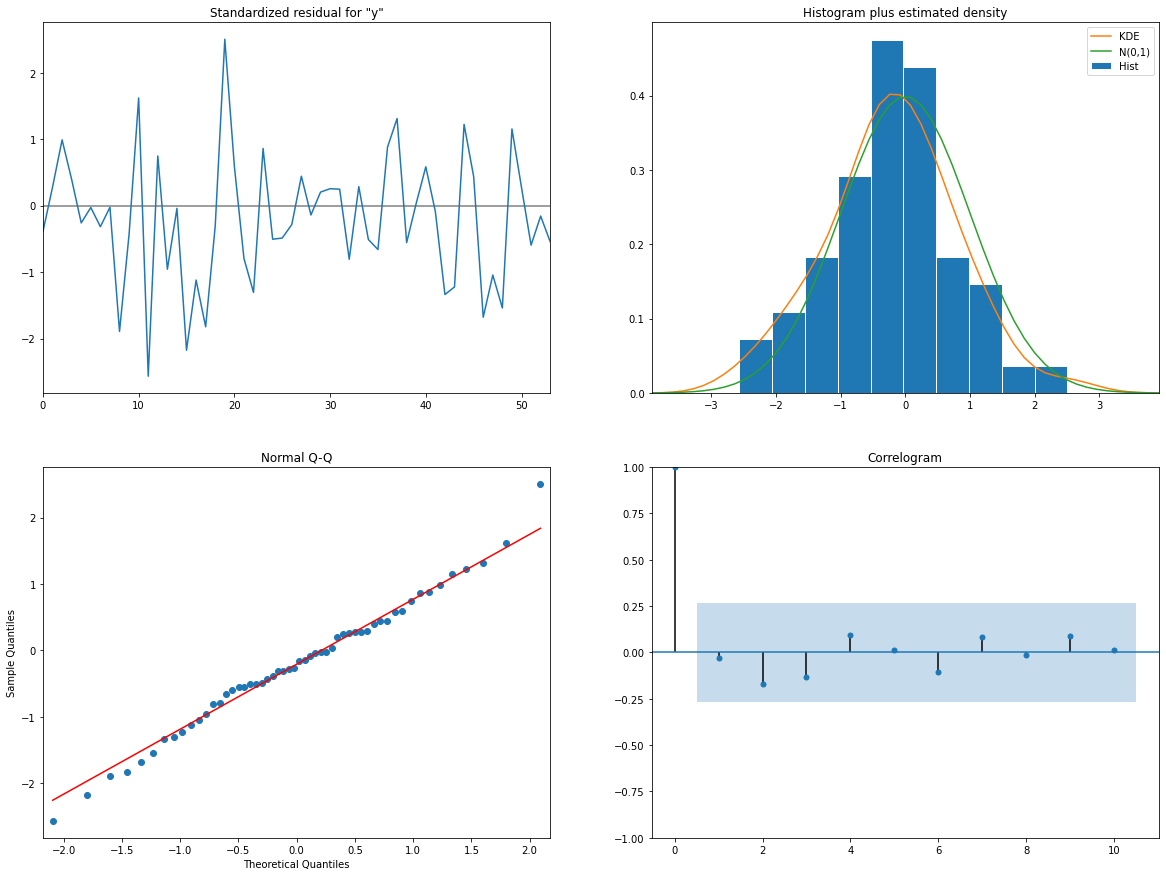

In [176]:
smodel_fitted.plot_diagnostics()
plt.plot()

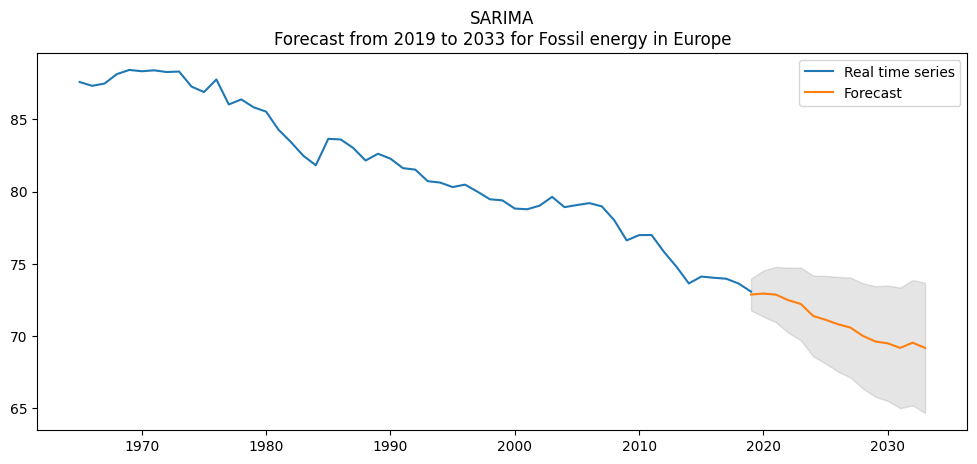

In [177]:
#@title Forecasting
""" PLOTTING RESULTS """
df[what].index = np.array(range(0, df.Renewables.count()))
fc = smodel_fitted.get_forecast(steps=n_pred).summary_frame()

upper = fc['mean_ci_upper']
lower = fc['mean_ci_lower']
forecast = fc['mean']
new_idxs = range(indexes.to_list()[-1], indexes.to_list()[-1] + n_pred)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(indexes, df[what].values, label = "Real time series")
plt.plot(new_idxs, forecast, label = "Forecast")
plt.fill_between(new_idxs, lower, upper, color='k', alpha=0.1);
plt.legend()
plt.title(f"SARIMA\nForecast from {new_idxs[0]} to {new_idxs[-1]} for {what} energy in {watch}")
plt.show()